# Compute resource drought statistics

This notebook uses the previously calculated binary resource drought masks to compute statistics about the frequency, duration, and magnitude of resource droughts at each GWL period

In [ ]:
import xarray as xr
from scipy.ndimage import label
import time
from renewable_data_load import *
import matplotlib.pyplot as plt

# Configure dask for parallel execution
#import dask
#dask.config.set(scheduler='threads', num_workers=4)  # Adjust num_workers to your CPU cores

In [ ]:
# Set data directory path
data_directory = "../../data/"

In [12]:
resource = "pv"
module = "utility"
domain = "d02"
variable = "cf"
frequency = "day"
simulation = "taiesm1"
reference_gwl = 0.8
future_gwl = 2.0

window_size = 60

simulations = ["mpi-esm1-2-hr", "miroc6", "taiesm1", 'ec-earth3',]
simulations = ['ec-earth3']

# Get bounds for reference GWL period
WRF_sim_name = sim_name_dict[simulation]
model = WRF_sim_name.split("_")[1]
ensemble_member = WRF_sim_name.split("_")[2]
ref_start_year, ref_end_year = get_gwl_crossing_period(model, ensemble_member, reference_gwl)
fut_start_year, fut_end_year = get_gwl_crossing_period(model, ensemble_member, future_gwl)


In [7]:
target_gwl = future_gwl

In [ ]:
def generate_drought_stats_from_mask(resource, module, domain, variable, simulation, target_gwl):

    def _calculate_all_drought_metrics(mask_1d, drought_values_1d):
        """
        Calculate all drought metrics for a 1D time series in a single pass.
        Returns three arrays with values at first day of each event, NaN elsewhere.
        
        Parameters:
        -----------
        mask_1d : 1D array
            Binary drought mask (1 = drought, 0 = no drought)
        drought_values_1d : 1D array
            Drought intensity values (from drought_ds)
        
        Returns:
        --------
        duration_1d : 1D array
            Duration at first day of each drought event, NaN elsewhere
        intensity_1d : 1D array
            Maximum intensity (minimum value) at first day of each drought event, NaN elsewhere
        magnitude_1d : 1D array
            Magnitude (sum of values) at first day of each drought event, NaN elsewhere
        """
        # Initialize output arrays with NaN
        duration_1d = np.full_like(mask_1d, np.nan, dtype=np.float32)
        intensity_1d = np.full_like(mask_1d, np.nan, dtype=np.float32)
        magnitude_1d = np.full_like(mask_1d, np.nan, dtype=np.float32)
        
        # Use scipy.ndimage.label to identify connected drought events (once!)
        labeled_array, num_events = label(mask_1d)
        
        # For each drought event, calculate all metrics in one pass
        for event_id in range(1, num_events + 1):
            # Find indices for this event
            event_indices = np.where(labeled_array == event_id)[0]
            
            if len(event_indices) > 0:
                # Get first index
                first_idx = event_indices[0]
                
                # Get values during this event
                event_values = drought_values_1d[event_indices]
                
                # Calculate all three metrics
                duration = len(event_indices)
                intensity = np.min(event_values)
                magnitude = np.sum(event_values)
                
                # Store all at first day
                duration_1d[first_idx] = duration
                intensity_1d[first_idx] = intensity
                magnitude_1d[first_idx] = magnitude
        
        return duration_1d, intensity_1d, magnitude_1d

    # load drought mask
    drought_mask_ds = xr.open_dataset(f"{data_directory}drought_masks/{resource}_{module}_{domain}_{variable}_{simulation}_gwl{target_gwl}_drought_mask_only.zarr")

    # load drought_ds
    threshold_file = f"{data_directory}thresholds/{resource}_{module}_{domain}_{variable}_{simulation}_gwlref{reference_gwl}_10th_pctile.nc"
    drought_threshold_ds = xr.open_dataset(threshold_file)
    ren_ds = get_ren_data_concat(resource, module, domain, variable, frequency, simulation)
    ren_ds = ren_ds.convert_calendar("noleap")

    # crop to drought mask time period
    ren_ds = ren_ds.sel(time=slice(drought_mask_ds.time.min().values, drought_mask_ds.time.max().values))

    # reshape array
    ds_doy = ren_ds.copy(deep=True)
    ds_doy['dayofyear'] = ds_doy.time.dt.dayofyear
    ds_doy['year'] = ds_doy.time.dt.year
    ds_doy = ds_doy.assign_coords(
        {"dayofyear":ds_doy.time.dt.dayofyear,
        "year":ds_doy.time.dt.year})
    # reshape time dimension
    ds_doy = ds_doy.drop_vars("time").set_index(time=['dayofyear','year']).unstack()

    drought_ds = (ds_doy - drought_threshold_ds.reference_gen).load()

    # reshape back into daily timeseries
    drought_ds = drought_ds.stack(time=['year','dayofyear'])
    drought_ds = drought_ds.reset_index("time").assign_coords(time=ren_ds.time)

    drought_ds = drought_ds.load()

    drought_mask_selection = drought_mask_ds['drought_mask']
    drought_ds_selection = drought_ds


    start_time_total = time.time()

        
    # Apply to all spatial locations using xr.apply_ufunc
    duration, intensity, magnitude = xr.apply_ufunc(
            _calculate_all_drought_metrics,
            drought_mask_selection,
            drought_ds_selection,
            input_core_dims=[['time'], ['time']],
            output_core_dims=[['time'], ['time'], ['time']],
            vectorize=True,
            dask='parallelized',
            output_dtypes=[np.float32, np.float32, np.float32]
        )
        
        
        # Save chunk to disk immediately to free memory
    drought_stats_ds = xr.Dataset({
            'duration': duration ,
            'intensity': intensity ,
            'magnitude': magnitude 
        })
        

    total_elapsed = time.time() - start_time_total
    print(f"\n{'='*60}")
    print(f"Completed in {total_elapsed:.2f} seconds ({total_elapsed/60:.2f} minutes)")

    print(f"{'='*60}")

    output_file = f"{data_directory}drought_stats/{resource}_{module}_{domain}_{variable}_{simulation}_gwl{target_gwl}_drought_mask_metrics.zarr"
    drought_stats_ds.to_zarr(output_file, mode='w')

    #return drought_stats_ds

In [ ]:
resource = "windpower"
module = "onshore"
domain = "d02"
variable = "cf"

# resource = "pv"
# module = "utility"
# domain = "d02"
# variable = "cf"

# resource = "windpower"
# module = "offshore"
# domain = "d03"
# variable = "cf"


for simulation in ["mpi-esm1-2-hr","miroc6",'ec-earth3','taiesm1']:
    for target_gwl in [0.8, 2.0]:
        print(f"Processing simulation: {simulation}, target GWL: {target_gwl}°C")
        drought_stats_ds = generate_drought_stats_from_mask(resource, module, domain, variable, simulation, target_gwl)

# Visualization of drought stats

In [ ]:
drought_stats_ds = xr.open_dataset(f"../../data/drought_stats/{resource}_{module}_{domain}_{variable}_{simulation}_gwl{target_gwl}_drought_mask_metrics.zarr")

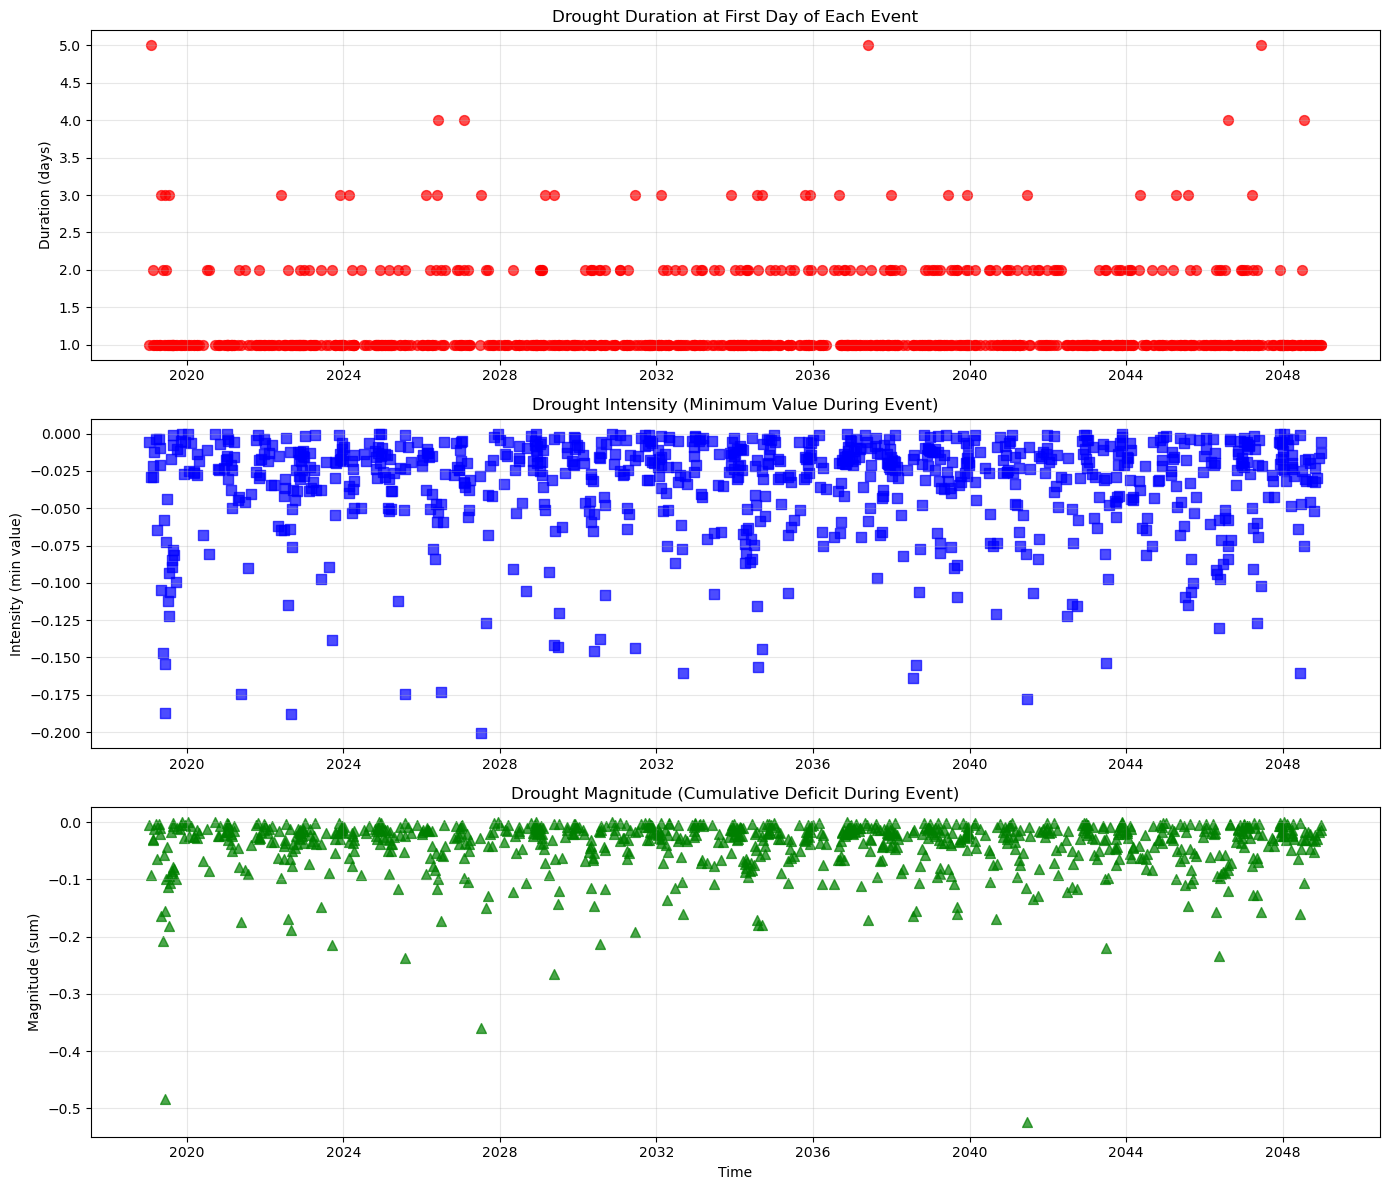

In [8]:
# Visualize all three drought metrics for a single location
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Get a single location
loc_duration = drought_stats_ds.duration.isel(x=110, y=230)
loc_intensity = drought_stats_ds.intensity.isel(x=110, y=230)
loc_magnitude = drought_stats_ds.magnitude.isel(x=110, y=230)

# Convert time for plotting
time_vals = pd.to_datetime([str(t) for t in loc_duration.time.values])

# Plot 1: Duration
mask_non_nan = ~np.isnan(loc_duration.values)
axes[0].scatter(time_vals[mask_non_nan], loc_duration.values[mask_non_nan], 
                alpha=0.7, s=50, c='red', marker='o')
axes[0].set_ylabel('Duration (days)')
axes[0].set_title('Drought Duration at First Day of Each Event')
axes[0].grid(True, alpha=0.3)

# Plot 2: Intensity (minimum value)
mask_non_nan = ~np.isnan(loc_intensity.values)
axes[1].scatter(time_vals[mask_non_nan], loc_intensity.values[mask_non_nan], 
                alpha=0.7, s=50, c='blue', marker='s')
axes[1].set_ylabel('Intensity (min value)')
axes[1].set_title('Drought Intensity (Minimum Value During Event)')
axes[1].grid(True, alpha=0.3)

# Plot 3: Magnitude (sum)
mask_non_nan = ~np.isnan(loc_magnitude.values)
axes[2].scatter(time_vals[mask_non_nan], loc_magnitude.values[mask_non_nan], 
                alpha=0.7, s=50, c='green', marker='^')
axes[2].set_ylabel('Magnitude (sum)')
axes[2].set_xlabel('Time')
axes[2].set_title('Drought Magnitude (Cumulative Deficit During Event)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()